In [1]:
%pip install pytesseract
%pip install opencv-python-headless
%pip install face_recognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566162 sha256=077e6931895c7885a77e3472c1cb40c960ec40384952f04f8d84e508ddf12ec0
  Stored in directory: /root/.cache/pip/wheels/04/52/ec/9355da79c29f160b038a20c784db2803c2f9fa2c8a462c176a
Successfully built face-recognition-models


In [2]:
!sudo apt install tesseract-ocr
!sudo apt install tesseract-ocr-fra

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 18 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 2s (2,629 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

In [3]:
import cv2
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'
import numpy as np
from skimage.metrics import structural_similarity as ssim
from google.colab.patches import cv2_imshow
import PIL
import base64
import io
from IPython.display import display, Javascript
from google.colab.output import eval_js
import face_recognition

In [4]:
def extract_text_from_id(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    text = pytesseract.image_to_string(gray)
    return text

def extract_face_from_id(image_path):
    image = cv2.imread(image_path)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)

    if len(faces) == 0:
        return None

    x, y, w, h = faces[0]
    return image[y:y+h, x:x+w]

def js_to_image(js_reply):
    image_bytes = base64.b64decode(js_reply.split(',')[1])
    image = PIL.Image.open(io.BytesIO(image_bytes))
    return cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

def take_photo():
    display(Javascript('''
        async function takePhoto() {
            const video = document.createElement('video');
            const stream = await navigator.mediaDevices.getUserMedia({video: true});
            document.body.appendChild(video);
            video.srcObject = stream;
            await new Promise((resolve) => video.onloadedmetadata = resolve);
            video.play();
            await new Promise((resolve) => setTimeout(resolve, 3000));
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getTracks().forEach(track => track.stop());
            document.body.removeChild(video);
            return canvas.toDataURL('image/jpeg');
        }
        google.colab.output.setIframeHeight(0, true, {maxHeight: 300})
        takePhoto().then(data => google.colab.kernel.invokeFunction('notebook.get_webcam_image', [data], {}));
    '''))

def capture_live_face():
    try:
        print("Initializing webcam...")
        take_photo()
        print("Waiting for webcam capture...")
        js_reply = eval_js('takePhoto()')
        if js_reply is None:
            print("No webcam data received")
            return None

        print("Processing webcam image...")
        frame = js_to_image(js_reply)

        # Debug: Show captured frame
        print("Showing captured frame...")
        cv2_imshow(frame)

        face_locations = face_recognition.face_locations(frame)
        if face_locations:
            top, right, bottom, left = face_locations[0]
            face_image = frame[top:bottom, left:right]
            return face_image
        else:
            print("No face detected in webcam image")
            return None
    except Exception as e:
        print(f"Error capturing live face: {str(e)}")
        return None

def preprocess_face(face):
    gray = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, (100, 100))
    gray = cv2.equalizeHist(gray)
    return gray


def compare_faces(face1, face2):
    face1_gray = cv2.cvtColor(face1, cv2.COLOR_BGR2GRAY)
    face2_gray = cv2.cvtColor(face2, cv2.COLOR_BGR2GRAY)
    face1_resized = cv2.resize(face1_gray, (100, 100))
    face2_resized = cv2.resize(face2_gray, (100, 100))
    return ssim(face1_resized, face2_resized)

# def compare_faces(face1, face2):
#     face1 = preprocess_face(face1)
#     face2 = preprocess_face(face2)

#     h, w = face1.shape
#     sections = [
#         (0, h//3), (h//3, 2*h//3), (2*h//3, h)
#     ]

#     scores = []
#     for (y1, y2) in sections:
#         ssim_score = ssim(face1[y1:y2, :], face2[y1:y2, :])
#         scores.append(ssim_score)

#     return np.mean(scores)


def histogram_similarity(img1, img2):
    hist1 = cv2.calcHist([img1], [0], None, [256], [0, 256])
    hist2 = cv2.calcHist([img2], [0], None, [256], [0, 256])
    cv2.normalize(hist1, hist1)
    cv2.normalize(hist2, hist2)
    return cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)

def kyc_verification(image_path):
    extracted_text = extract_text_from_id(image_path)
    id_face = extract_face_from_id(image_path)

    if id_face is None:
        return {"error": "No face detected on ID"}

    print("Please position your face in front of the camera...")
    live_face = capture_live_face()

    similarity = compare_faces(id_face, live_face)
    hist_score = histogram_similarity(id_face, live_face)
    sim_score = (similarity * 0.7) + (hist_score * 0.3)

    return {
        "similarity_score": similarity,
        "hist_score": hist_score,
        "Extracted Text": extracted_text,
        "sim_score": sim_score,
        "Verification Status": "Matched" if similarity > 0.5 else "Not Matched"
    }




Please position your face in front of the camera...
Initializing webcam...


<IPython.core.display.Javascript object>

Waiting for webcam capture...
Processing webcam image...
Showing captured frame...


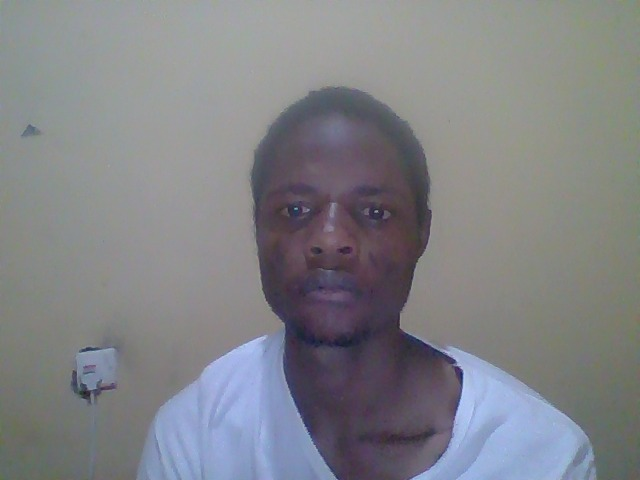

{'similarity_score': 0.3250826355614105, 'hist_score': -0.11569159216735507, 'Extracted Text': 'JAMHURI YA KENYA g\\0/9 REPUBLIC OF KENYA\nwaser 290319802 cama 39870347\n\nPAUL WAKO\n\n \n\x0c', 'sim_score': 0.19285036724278082, 'Verification Status': 'Not Matched'}


In [7]:
image_path = "/content/drive/MyDrive/IMG_20250130_091857_852(0).jpg"
result = kyc_verification(image_path)
print(result)